
# Projecte integrador — Temperatura i consum elèctric (Solució)

Aquest notebook resol pas a pas l'activitat descrita a **"Projecte integrador — Temperatura i consum elèctric"**.  
Treballarem el dataset de Kaggle **Hourly energy demand, generation, prices and weather – Spain** i seguirem els objectius i tasques proposats: exploració, preparació de dades diàries, regressió lineal, avaluació, visualització i una extensió amb regressió polinòmica.

> Dataset: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

**Nota:** Pots executar el bloc de descàrrega via API de Kaggle (opcional) o bé indicar la ruta on tinguis els fitxers descarregats.



## 1) Dependències i configuració
Executa aquesta cel·la si et cal instal·lar llibreries. Si ja les tens, la pots ometre.


In [ ]:

# (Opcional) Instal·lació de dependències si cal (comenta si ja ho tens al teu entorn)
# %pip install pandas numpy scikit-learn matplotlib kaggle



## 2) (Opcional) Descarregar dades amb l'API de Kaggle
1. Crea (o descarrega) el token **kaggle.json** des de https://www.kaggle.com/settings/account  
2. Desa'l a `~/.kaggle/kaggle.json` o al directori actual i dona permisos 600 si cal.
3. Executa la cel·la per descarregar i descomprimir el dataset a `./data_kaggle`.

Si prefereixes, **salta aquest pas** i indica manualment la ruta on tens `energy_dataset.csv` i `weather_features.csv`.


In [ ]:

#import os, zipfile, pathlib

# DATA_DIR = pathlib.Path("./data_kaggle")
# DATA_DIR.mkdir(parents=True, exist_ok=True)

# Descomenta per fer servir l'API de Kaggle (requereix que el teu entorn tingui internet i el token configurat).
# !kaggle datasets download -d nicholasjhana/energy-consumption-generation-prices-and-weather -p "{DATA_DIR}"
# zip_path = next(DATA_DIR.glob("*.zip"), None)
# if zip_path:
#     with zipfile.ZipFile(zip_path, 'r') as z:
#         z.extractall(DATA_DIR)
#     print("Descomprimit a:", DATA_DIR)
# else:
#     print("No s'ha trobat el .zip. Comprova la descàrrega.")



,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n



## 3) Carrega de dades
A continuació indiquem **on són els fitxers**. Si has descarregat amb Kaggle, sovint trobaràs:
- `energy_dataset.csv`
- `weather_features.csv`

> En alguns mirrors el fitxer de meteorologia pot tenir variacions de nom o d'estructura. El codi intenta ser **robust** per detectar la columna de temperatura i la marca temporal.


In [18]:

import os
import pandas as pd
import numpy as np

energy_csv_path = "energy_dataset.csv"
weather_csv_path = "weather_features.csv"
energy_data = pd.read_csv(energy_csv_path)
weather_data = pd.read_csv(weather_csv_path)

#energy_data.head()
weather_data.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n



## 4) Preparació de dades horàries → diàries
- Convertirem la **marca temporal** a `datetime` i la normalitzarem a la columna `time`.
- Del dataset d'energia, agafarem el camp de **consum** horari (p.ex. `total load actual`) i agregarem **per dia** (suma → MWh aproximats).
- Del dataset meteorològic, calculem la **temperatura mitjana diària**. Si hi ha múltiples ciutats, farem mitjana entre ciutats primer per hora i després per dia.


In [19]:
# Columnes clau
tcol_e = "time" # Columna de temps del dataset energètic
tcol_w = "dt_iso"  # Columna de temps del dataset meteorològic
consum_col  = "total load actual"  # Columna de consum energètic
wtemp_w = "temp"  # Columna de temperatura al dataset meteorològic

energy_data[tcol_e] = pd.to_datetime(energy_data[tcol_e], errors="coerce", utc=True).dt.tz_convert(None)
weather_data[tcol_w] = pd.to_datetime(weather_data[tcol_w], errors="coerce", utc=True).dt.tz_convert(None)

# Agregació a nivell diari
energy_data["date"] = energy_data[tcol_e].dt.date
weather_data["date"] = weather_data[tcol_w].dt.date


# Consum diari: suma de MW per cada hora ≈ MWh/dia
daily_energy = energy_data.groupby("date", as_index=False)[consum_col].sum().rename(columns={consum_col: "EnergyConsumption_MWh"})

# Temperatura diària: mitjana
daily_temp = weather_data.groupby("date", as_index=False)[wtemp_w].mean().rename(columns={wtemp_w: "Temperature_C"})

daily = pd.merge(daily_temp, daily_energy, on="date", how="inner")
daily["date"] = pd.to_datetime(daily["date"])
daily = daily.sort_values("date").reset_index(drop=True)

print("🔹 Files diàries:", len(daily))
display(daily.head())


🔹 Files diàries: 1462


,date,Temperature_C,EnergyConsumption_MWh
0,2014-12-31,272.491463,25385.0
1,2015-01-01,277.001207,575207.0
2,2015-01-02,277.951217,652525.0
3,2015-01-03,278.829727,602346.0
4,2015-01-04,279.643354,650518.0



## 5) Exploració inicial i gràfic de dispersió


                      date  Temperature_C  EnergyConsumption_MWh
count                 1462    1462.000000            1462.000000
mean   2016-12-30 12:00:00     289.656252          687548.844733
min    2014-12-31 00:00:00     272.491463           25385.000000
25%    2015-12-31 06:00:00     284.265432          649735.000000
50%    2016-12-30 12:00:00     289.179022          687890.000000
75%    2017-12-30 18:00:00     295.298784          739400.250000
max    2018-12-31 00:00:00     302.815868          848155.000000
std                    NaN       6.464381           68798.683011


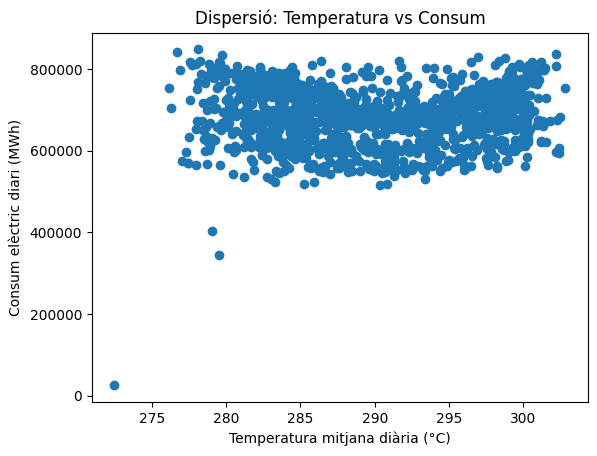

In [20]:

import matplotlib.pyplot as plt

if 'daily' in globals():
    print(daily.describe(include='all'))

    plt.figure()
    plt.scatter(daily["Temperature_C"], daily["EnergyConsumption_MWh"])
    plt.xlabel("Temperatura mitjana diària (°C)")
    plt.ylabel("Consum elèctric diari (MWh)")
    plt.title("Dispersió: Temperatura vs Consum")
    plt.show()
else:
    print("Carrega les dades primer.")



## 6) Model de regressió lineal
- Variables: `X = Temperature_C`, `y = EnergyConsumption_MWh`
- Informe de pendent i intercept.


In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


X = daily[["Temperature_C"]].values
y = daily["EnergyConsumption_MWh"].values


linreg = LinearRegression()
linreg.fit(X, y)

y_pred = linreg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Pendent (w): {linreg.coef_[0]:.3f}")
print(f"Intercept (b): {linreg.intercept_:.3f}")
print(f"MSE (test): {mse:.2f}")
print(f"R² (test): {r2:.3f}")


Pendent (w): -7.576
Intercept (b): 689765.409
MSE (test): 4752012136.82
R² (test): -0.000



## 7) Visualització de la recta ajustada


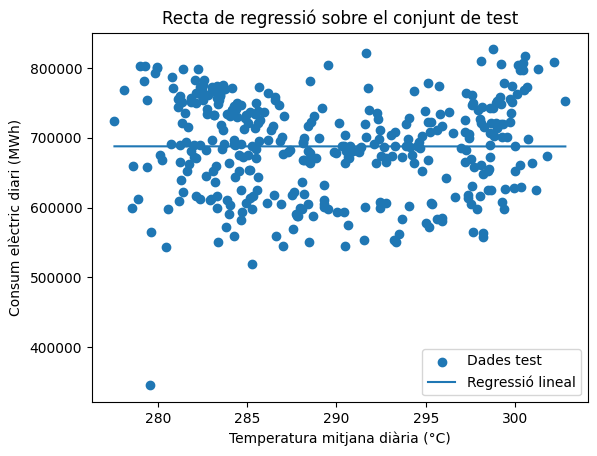

In [21]:

if 'daily' in globals():
    plt.figure()
    plt.scatter(X_test, y_test, label="Dades test")
    # Recta
    x_line = np.linspace(X_test.min(), X_test.max(), 100).reshape(-1, 1)
    y_line = linreg.predict(x_line)
    plt.plot(x_line, y_line, label="Regressió lineal")
    plt.xlabel("Temperatura mitjana diària (°C)")
    plt.ylabel("Consum elèctric diari (MWh)")
    plt.title("Recta de regressió sobre el conjunt de test")
    plt.legend()
    plt.show()
else:
    print("Carrega les dades primer.")



## 8) Anàlisi amb subset de temperatures
A vegades la relació és quasi-lineal **només** en un interval de temperatures. Provarem a restringir l'anàlisi a un rang central (p.ex. percentils 10–90).


In [ ]:

def fit_and_report(df, X_col="Temperature_C", y_col="EnergyConsumption_MWh", test_size=0.25, seed=42):
    X = df[[X_col]].values
    y = df[y_col].values
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=seed)
    model = LinearRegression().fit(X_tr, y_tr)
    pred = model.predict(X_te)
    return {
        "w": float(model.coef_[0]),
        "b": float(model.intercept_),
        "mse": float(mean_squared_error(y_te, pred)),
        "r2": float(r2_score(y_te, pred)),
        "model": model,
        "X_test": X_te,
        "y_test": y_te
    }

if 'daily' in globals():
    p_low, p_high = np.percentile(daily["Temperature_C"].dropna(), [10, 90])
    subset = daily[(daily["Temperature_C"]>=p_low) & (daily["Temperature_C"]<=p_high)].copy()
    base_res = fit_and_report(daily)
    sub_res  = fit_and_report(subset)

    print("Model global:  w={w:.3f}  b={b:.1f}  MSE={mse:.1f}  R²={r2:.3f}".format(**base_res))
    print("Model subset:  w={w:.3f}  b={b:.1f}  MSE={mse:.1f}  R²={r2:.3f}".format(**sub_res))

    # Visualització del subset
    plt.figure()
    plt.scatter(sub_res["X_test"], sub_res["y_test"], label="Dades test (subset)")
    x_line = np.linspace(sub_res["X_test"].min(), sub_res["X_test"].max(), 100).reshape(-1, 1)
    y_line = sub_res["model"].predict(x_line)
    plt.plot(x_line, y_line, label="Regressió lineal (subset)")
    plt.xlabel("Temperatura mitjana diària (°C)")
    plt.ylabel("Consum elèctric diari (MWh)")
    plt.title("Recta de regressió en rang [P10, P90] de temperatura")
    plt.legend()
    plt.show()
else:
    print("Carrega les dades primer.")



## 9) (EXTRA) Regressió polinòmica grau 2
Si la relació mostra corba, un model polinòmic pot capturar-la millor. Compararem R² amb el model lineal.


In [ ]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

if 'daily' in globals():
    X = daily[["Temperature_C"]].values
    y = daily["EnergyConsumption_MWh"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    poly2 = Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin", LinearRegression())
    ])
    poly2.fit(X_train, y_train)
    y_pred2 = poly2.predict(X_test)

    mse2 = mean_squared_error(y_test, y_pred2)
    r22  = r2_score(y_test, y_pred2)

    print(f"(Lineal)  MSE={mse:.2f}  R²={r2:.3f}")
    print(f"(Polin2) MSE={mse2:.2f} R²={r22:.3f}")

    # Visualització de la corba polinòmica
    plt.figure()
    plt.scatter(X_test, y_test, label="Dades test")
    x_line = np.linspace(X_test.min(), X_test.max(), 200).reshape(-1, 1)
    y_line = poly2.predict(x_line)
    plt.plot(x_line, y_line, label="Regressió polinòmica (grau 2)")
    plt.xlabel("Temperatura mitjana diària (°C)")
    plt.ylabel("Consum elèctric diari (MWh)")
    plt.title("Ajust polinòmic grau 2")
    plt.legend()
    plt.show()
else:
    print("Carrega les dades primer.")



## 10) Predicció a 0 °C i exportació de dades


In [ ]:

if 'daily' in globals():
    # Predicció a 0°C amb el model lineal bàsic entrenat abans
    if 'linreg' in globals():
        y0 = linreg.predict(np.array([[0.0]]))[0]
        print(f"Predicció de consum a 0°C (model lineal): {y0:.1f} MWh/dia")
    else:
        print("Entrena primer el model lineal (secció 6).")

    # Desa el dataset diari per reutilitzar-lo
    out_path = Path("daily_energy_temperature.csv")
    daily.to_csv(out_path, index=False)
    print("S'ha desat:", out_path.resolve())
else:
    print("Carrega les dades primer.")



## 11) Preguntes de reflexió (respostes guiades)
1. **Quin signe té la pendent (w)?** Explica si augmentar la temperatura incrementa o redueix el consum.
2. **Consum previst a 0°C**: La xifra és raonable? Per què?
3. **Bondat del model**: Amb el teu R², el model lineal explica prou bé la variabilitat?
4. **Com millorar el model?** (més variables: dia de la setmana, estacionalitat, festius, pluja, vent…)
5. **Altres factors** que afecten el consum (comportament humà, econòmics, polítiques energètiques…)
6. **Contextos inadequats** pel model lineal directe (estacionalitat forta, canvis sobtats de preu…)
7. **Aspectes ètics/privacitat**: dades de consum poden revelar hàbits; cal anonimitzar i justificar usos.



## 12) Conclusions
- Resumeix la relació observada entre temperatura i consum.
- Indica si el model lineal és suficient o si el polinòmic (o un altre) resulta més adequat.
- Deixa línies de treball futures (més variables, models regularitzats, sèries temporals, efectes de cap de setmana/festius).
